In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/DMA Kaggle"

In [3]:
%cd /content/drive/My Drive/DMA Kaggle

/content/drive/My Drive/DMA Kaggle


**Kaggle Challenge starts from here!!**

Yin Qiu

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# check missing values
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
print(df_train.shape, df_test.shape)

(891, 12) (418, 11)


In [10]:
# check data types
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

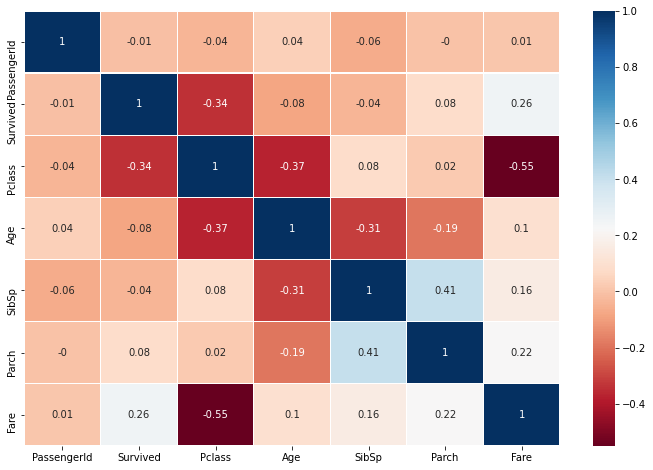

In [11]:
# plot a heatmap to see correlations for each pair of variables
plt.figure(figsize=(12,8))
correlation_matrix = df_train.corr().round(2)
sns.heatmap(data=correlation_matrix, annot = True, linewidths= 0.2, cmap="RdBu")
plt.show()

**From the heatmap above, positive correlations are found in Pclass and Fare, Pclass and Age, SibSp and Age; negative correlations are found in Parch and Age, Parch and SibSp, Parch and Fare. The collinearity problem is not very significant, so we keep all the features. However, we can surely do some feature engineering.**

In [12]:
# create column list of numerical features; we keep age and will impute missing values
num_feat = ['Age', 'Fare', 'SibSp', 'Parch']
# create column list of categorical features; we drop PassengerId, name and ticket (not quite meaningful in training), 
# and also cabin (too much missing)
categ_feat = ['Sex', 'Pclass', 'Embarked']

In [13]:
# separate features and label
X = df_train.drop(['Survived'], axis=1)
y = df_train['Survived']

In [14]:
# impute missing values in Embarked with mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X[['Embarked']])
X[['Embarked']] = imp_mode.transform(X[['Embarked']])
df_test[['Embarked']] = imp_mode.transform(df_test[['Embarked']])

# impute missing values in Age with mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X[['Age']])
X[['Age']] = imp_mean.transform(X[['Age']])
df_test[['Age']] = imp_mean.transform(df_test[['Age']])

# impute missing value in Fare in df_test with mean
imp_mean.fit(df_test[['Fare']])
df_test[['Fare']] = imp_mean.transform(df_test[['Fare']])

In [15]:
# Dict to Vectorizer to transform features to all numerical, incl categorical variable
X = X.drop(['Ticket', 'Cabin', 'PassengerId', 'Name'], axis=1).to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

In [16]:
df_test_pid = df_test[['PassengerId']] # save for catenation when submit
df_test = df_test.drop(['Ticket', 'Cabin', 'PassengerId', 'Name'], axis=1).to_dict(orient='records')
vec = DictVectorizer()
df_test = vec.fit_transform(df_test).toarray()

In [17]:
# split training data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    train_size=0.8, test_size=0.2, \
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 10) (179, 10) (712,) (179,)


In [19]:
# Model 1: Run random forest classifer, tune hyper-parameters with GridSearchCV
parameters_grid = {'criterion': ['entropy'], 
                   'n_estimators': list(range(10, 101, 20)),
                   'max_depth': list(range(1,11)),
                   'min_samples_leaf': [1,2],
                   'min_samples_split': [5,10]}
rfc = RandomForestClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search = GridSearchCV(rfc, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X_train, y_train)

print('Best score on training set: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score on training set: 0.833
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}


In [20]:
rfc_best = grid_search.best_estimator_
print("Best random forest model on testing score: {}".format(rfc_best.score(X_test, y_test).round(3)))

Best random forest model on testing score: 0.816


**The Random Forest Classifer has achieved reasonably good score on both training (83.3%) and testing (81.6%), when hyper-parameters are:**

**'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70**

In [21]:
# Model 2: Run gradient boosting classifier, tune hyperparameters with GridSearchCV
param_grid_gb = {'loss':['deviance', 'exponential'],
                 'learning_rate':np.arange(0.01,0.2,0.01),
                 'max_depth':[4,8],
                 'max_features': [0.3,0.5]}
              
gbc = GradientBoostingClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5)
grid_search_gb = GridSearchCV(gbc, param_grid=param_grid_gb, cv=cr_val)
grid_search_gb.fit(X_train, y_train)

print('Best score on training set: {}'.format((grid_search_gb.best_score_).round(3)))
print('Best parameters: {}'.format(grid_search_gb.best_params_))

Best score on training set: 0.837
Best parameters: {'learning_rate': 0.09999999999999999, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.3}


In [22]:
gbc_best = grid_search_gb.best_estimator_
print("Best gradient boosting model on testing score: ", gbc_best.score(X_test, y_test).round(3))

Best gradient boosting model on testing score:  0.821


**The Grandient Boosting Classifer has achieved better score than Random Forest Classifer. Training score is 83.7% and testing score is 82.1%, when the hyper-parameters are:**

**'learning_rate': 0.09999999999999999, 'loss': 'exponential', 'max_depth': 4, 'max_features': 0.3**



In [23]:
# Model 3: Run neural network MLP Classifier, tune hyperparameters with GridSearchCV
sc=StandardScaler() # standardscale dataset so it can converge better
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

parameter_space = {
    'hidden_layer_sizes': [(10,), (20,10),(10,10)],
    'activation': ['tanh', 'relu',"logistic"],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}

mlp = MLPClassifier(max_iter=300, random_state=42)
cr_val = StratifiedKFold(n_splits=5)
grid_search_mlp = GridSearchCV(mlp, param_grid=parameter_space, n_jobs=-1, cv=cr_val)
grid_search_mlp.fit(X_train_scaled, y_train)

print('Best score on training set: {}'.format((grid_search_mlp.best_score_).round(3)))
print('Best parameters: {}'.format(grid_search_mlp.best_params_))

Best score on training set: 0.822
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [25]:
mlp_best = grid_search_mlp.best_estimator_
print('Best MLP Classifier score on testing set: {}'.format(mlp_best.score(X_test, y_test).round(3)))

Best MLP Classifier score on testing set: 0.709


**The MLP classifier is a bit overfitting and need more tuning. Training score is 82.9% and testing score is 73.7%. It is still performing worse than the Random Forest and Gradient Boosting.**

**So far, the best model is Gradient Boosting Classifier**

Text(0.5, 1.0, 'Feature Importance')

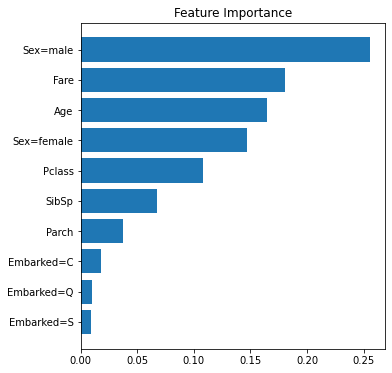

In [30]:
# compute the feature importance to see which features are more important to determine survival
feature_importance = gbc_best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(vec.feature_names_)[sorted_idx])
plt.title('Feature Importance')

**Who are more likely to survive? We conduct some exploration data analysis.**

In [33]:
# sex vs survived
pd.crosstab(df_train.Sex, df_train.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


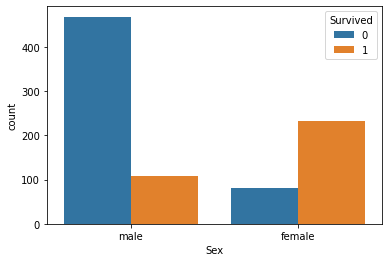

In [40]:
sns.countplot(x='Sex',hue='Survived',data=df_train)

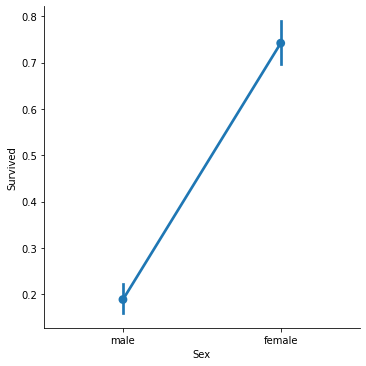

In [41]:
sns.catplot(x='Sex', y='Survived', data=df_train, kind='point')

In [36]:
# pclass vs survived
pd.crosstab(df_train.Pclass,df_train.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


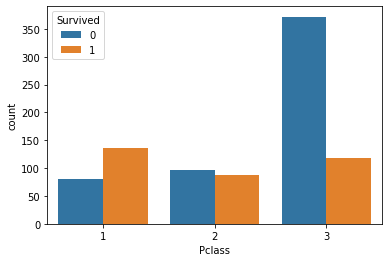

In [39]:
sns.countplot(x='Pclass',hue='Survived',data=df_train)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


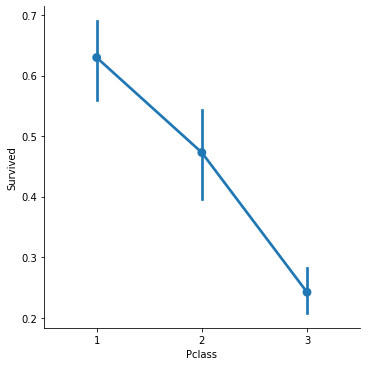

In [42]:
sns.catplot('Pclass', 'Survived', data=df_train, kind='point')

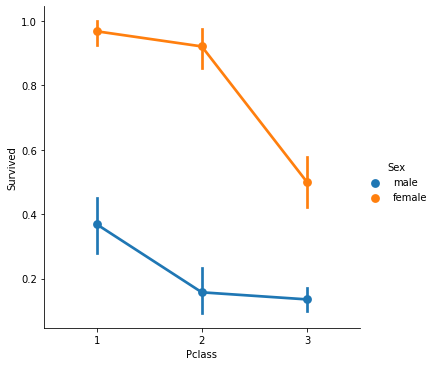

In [43]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=df_train, kind='point')

In [45]:
# embarked vs survived
pd.crosstab(df_train.Embarked,df_train.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


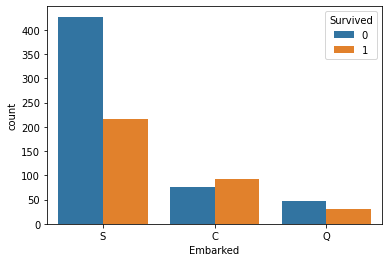

In [46]:
sns.countplot(x='Embarked', hue= 'Survived',data=df_train)

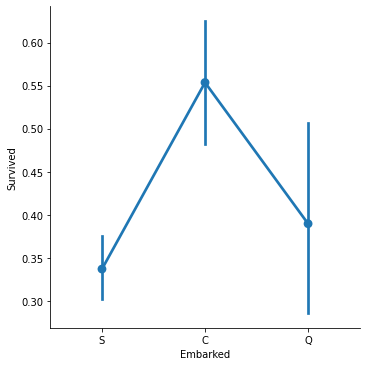

In [48]:
sns.catplot(x='Embarked', y='Survived', data=df_train, kind='point')

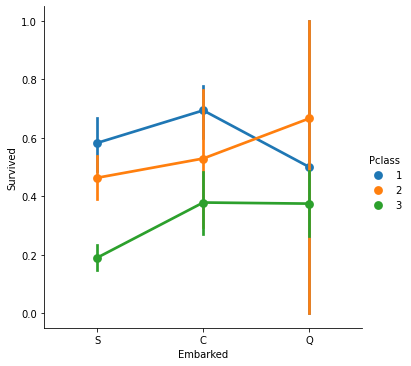

In [49]:
sns.catplot(x='Embarked', y='Survived', hue='Pclass', data=df_train, kind='point')

**Observations about survival:**

Female is more likely to survive than male in general and in segments of Pclass and Embarked. Sex is a very important feature for modeling.

Pclass 1 is more likely to survive than lower classes. This trend hold true for Pclass 1 and 3, but slightly different for Pclass 2. Still, Pclass is an important feature.

Embarking from C port is most likely to survive. However, the ranking of survival for male is C, S, Q and for female is C, Q, S. Overall, Embarked is also important feature.

In [31]:
# save result to dataframe submission
submission = df_test_pid
submission['Survived'] = gbc_best.predict(df_test)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [32]:
# save result as csv file. done!
submission.to_csv('submission.csv', index=False)